<a href="https://colab.research.google.com/github/Yoseph-Zuskin/midaspy/blob/master/example/monthly_CPI_daily_stock_index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mixed Frequency Time-Series Forecasting Tutorial Using MIDAS Regression

#### This library is still in alpha stage of development. To install, run the following command:

In [9]:
!pip install git+https://github.com/Yoseph-Zuskin/midaspy.git@master#egg=midaspy

  Cloning https://github.com/Yoseph-Zuskin/midaspy.git (to revision master) to /tmp/pip-install-_yi8hphx/midaspy_d2cc60e676604911908995de583d091f
  Running command git clone --filter=blob:none --quiet https://github.com/Yoseph-Zuskin/midaspy.git /tmp/pip-install-_yi8hphx/midaspy_d2cc60e676604911908995de583d091f
  Resolved https://github.com/Yoseph-Zuskin/midaspy.git to commit 191108ea02954558c1a2e1d938ebce7f9a1d16a3
  Preparing metadata (setup.py) ... done
  Created wheel for midaspy: filename=midaspy-0.0.1-py3-none-any.whl size=13588 sha256=2a31510481af73d57c250a7cd9d13dabe82ba86094e34889f47f7fcdcf824762
  Stored in directory: /tmp/pip-ephem-wheel-cache-rftxz9yz/wheels/5a/4a/24/5989298b34160761e4626a22af06256bb23884e222ca3282d2
Successfully built midaspy


#### Now that the library is installed, load it along with Pandas:

In [10]:
%matplotlib inline
import numpy as np
import pandas as pd
from itertools import product
from midaspy.iolib import *
from midaspy.model import MIDASRegressor

#### Use the following functions to extract CSV file from zip files and load data from Statistics Canada:

In [11]:
from zipfile import ZipFile
from requests import get
from io import BytesIO
def extract_zip_from_url(link):
    """
    Extract ZIP from URL
    this function extracts the bytes data from within ZIP files that are found online

    Parameters
        link (str): URL link for the ZIP file

    Returns
        output (dict): dictionary of zipped files' bytes data
    """
    u=get(link)
    f=BytesIO()
    f.write(u.content)
    input_zip=ZipFile(f)
    output={i:input_zip.read(i) for i in input_zip.namelist()}
    return output

In [12]:
def load_stats_can_data(pid,low_memory=False):
    """
    Load Statistics Canada Data
    custom function to load data directly from an online zip file into a pandas dataframe

    Parameters
        pid (str): product id for the Statistics Canada online data asset
        low_memory (bool): memory setting for the pandas.read_csv function

    Returns
        df (pandas.DataFrame): resulting dataframe of all variables from the data asset
    """
    # first extract the zip file from the Statistics Canada website using extract_zip_from_url
    online_zip=extract_zip_from_url('https://www150.statcan.gc.ca/n1/tbl/csv/{}-eng.zip'.format(pid))
    # then load the resulting csv file for the data asset and set the date to datetime64[ns] data type
    df=pd.read_csv(BytesIO(online_zip['{}.csv'.format(pid)]),parse_dates=[0],low_memory=low_memory)
    df=df[df.iloc[:,1]=='Canada'] # filter the data asset to exclude data related to the territories
    variables=list(set(df.iloc[:,3])) # define list of variable types as they appear in the 4th column
    variable_series={} # store each variable series in this temporary dictionary instance
    for v in variables: # iterable over all the variables in this data asset
        series=df[df.iloc[:,3]==v].set_index(df.columns[0]).VALUE # filter dataframe for the variable
        series.rename(v,inplace=True) # rename the series to what Statistics Canada refers to it as
        variable_series[v]=series # store the resulting series in the temporary dictionary instance
    df=pd.DataFrame() # create dataframe to store all combined series
    for v in variables: # iterate over each variable and merge it as this works when pd.concat may fail
        df=pd.merge(right=df,left=variable_series[v],right_index=True,left_index=True,how='outer')
    return df

### Part 1: Load Raw Data

In [13]:
# Load the Canadian Consumer Price Index data frm Statistics Canada
cpi_df=load_stats_can_data('10100106')
col='Consumer Price Index (CPI) inversely weighted by volatility and is adjusted to exclude the effect of changes in indirect taxes (CPIW) (year-over-year percent change)'
cpi_df=cpi_df[~cpi_df.index.duplicated(keep='first')][col]

In [22]:
cpi_df.head()

,Consumer Price Index (CPI) inversely weighted by volatility and is adjusted to exclude the effect of changes in indirect taxes (CPIW) (year-over-year percent change)
REF_DATE,
1979-11-01,9.3
1979-12-01,9.4
1980-01-01,9.3
1980-02-01,9.4
1980-03-01,9.3


In [16]:
# load the S&P/TSX Composite index historical daily data from Yahoo Finance
import yfinance as yf

# load the S&P/TSX Composite index historical daily data from Yahoo Finance
tsx = yf.download('^GSPTSE', period='max', interval='1d')

/tmp/ipython-input-16-885861312.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  tsx = yf.download('^GSPTSE', period='max', interval='1d')
[*********************100%***********************]  1 of 1 completed


In [20]:
tsx.head()

Price,Close,High,Low,Open,Volume
Date,,,,,
1979-06-29,1614.290161,1615.686630,1610.599484,1610.599484,0
1979-07-03,1598.729858,1609.502360,1597.632554,1609.502360,0
1979-07-04,1587.358643,1597.432969,1585.463443,1597.432969,0
1979-07-05,1579.877808,1585.962293,1578.481338,1585.962293,0
1979-07-06,1582.570923,1582.570923,1574.292073,1579.877828,0


In [21]:
tsx.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11551 entries, 1979-06-29 to 2025-06-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   11551 non-null  float64
 1   High    11551 non-null  float64
 2   Low     11551 non-null  float64
 3   Open    11551 non-null  float64
 4   Volume  11551 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 541.5 KB


In [19]:
tsx.columns = tsx.columns.droplevel(level=1)

### Part 2: Explore & Process the Data

<Axes: title={'center': 'Consumer Price Index (CPI) inversely weighted by volatility and is adjusted to exclude the effect of changes in indirect taxes (CPIW) (year-over-year percent change)'}, xlabel='REF_DATE'>

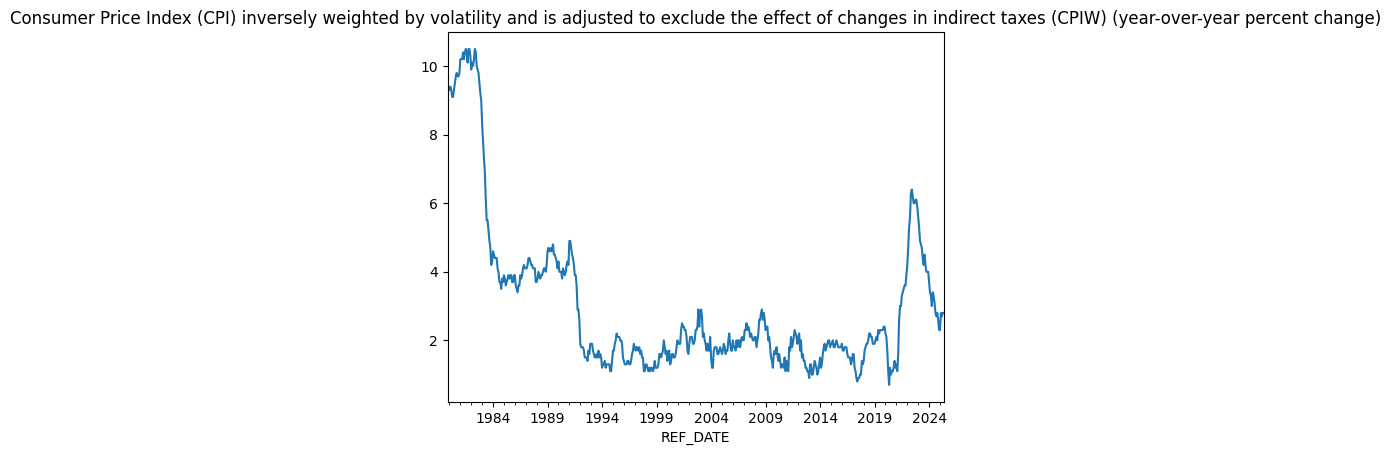

In [23]:
cpi_df.plot(title=col)

In [24]:
tsx.index

DatetimeIndex(['1979-06-29', '1979-07-03', '1979-07-04', '1979-07-05',
               '1979-07-06', '1979-07-09', '1979-07-10', '1979-07-11',
               '1979-07-12', '1979-07-13',
               ...
               '2025-06-17', '2025-06-18', '2025-06-19', '2025-06-20',
               '2025-06-23', '2025-06-24', '2025-06-25', '2025-06-26',
               '2025-06-27', '2025-06-30'],
              dtype='datetime64[ns]', name='Date', length=11551, freq=None)

In [25]:
# the TSX data exists only for non-holiday weekdays but to keep all months' data comparable
# let's assume that there is no change in economic conditions on those days, so we can forward
# fill missing data over a continuous daily date range to address this issue by first creating
# an empty dataframe of all days in between the start and end dates of the available TSX data
continuous_daterange=pd.date_range(tsx.index[0],tsx.index[-1]).to_frame().drop(0,axis=1)
# then concatenate this continuous date range with the TSX data and do a forward fill
tsx=pd.concat([continuous_daterange,tsx],axis=1).ffill()
del continuous_daterange # delete the temporary continuous_daterange index

In [27]:
tsx.head()

,Close,High,Low,Open,Volume
1979-06-29,1614.290161,1615.68663,1610.599484,1610.599484,0.0
1979-06-30,1614.290161,1615.68663,1610.599484,1610.599484,0.0
1979-07-01,1614.290161,1615.68663,1610.599484,1610.599484,0.0
1979-07-02,1614.290161,1615.68663,1610.599484,1610.599484,0.0
1979-07-03,1598.729858,1609.50236,1597.632554,1609.502360,0.0


In [28]:
# it appears that the volume is zero until November 1984, so only daily data from 1985 onward will be used
tsx[tsx.Volume!=0].dropna().head()

,Close,High,Low,Open,Volume
1984-11-05,2383.731445,2383.731445,2362.784772,2363.084059,112400.0
1984-11-06,2416.846924,2416.846924,2394.802948,2394.802948,161600.0
1984-11-07,2407.670166,2420.836596,2406.772305,2417.744371,105500.0
1984-11-08,2409.066406,2412.956648,2401.086723,2403.281087,90400.0
1984-11-09,2410.363281,2419.639713,2410.063994,2414.951697,75700.0


### Part 3: Exploring the polynomial weighting methods

<Axes: >

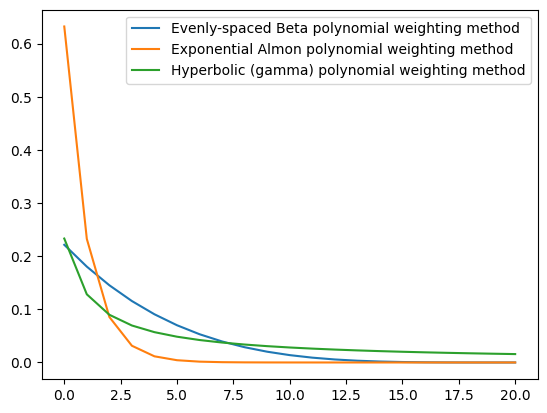

In [29]:
# these are the baseline weights for nlag observations using each of the three possible polynomial weighting methods
nlags = 21
pd.concat([
    pd.Series(BetaWeights(1., 5.).weights(nlags)).rename("Evenly-spaced Beta polynomial weighting method"),
    pd.Series(ExpAlmonWeights(-1., 0.).weights(nlags)).rename("Exponential Almon polynomial weighting method"),
    pd.Series(HyperbolicWeights(0.1).weights(nlags)).rename("Hyperbolic (gamma) polynomial weighting method")
], axis=1).plot()

In [30]:
list1 = np.linspace(-1.5, 1.5, 15).tolist()
list2 = np.linspace(-10, 10, 15).tolist()
beta_combos = list(product(list1, list2))

In [31]:
nlags = 21
beta_weightings = pd.DataFrame()
for combo in beta_combos:
    beta_weightings = pd.concat([beta_weightings,
                                pd.Series(BetaWeights(*combo).weights(nlags)).rename(str(combo))],
                               axis=1)

<Axes: >

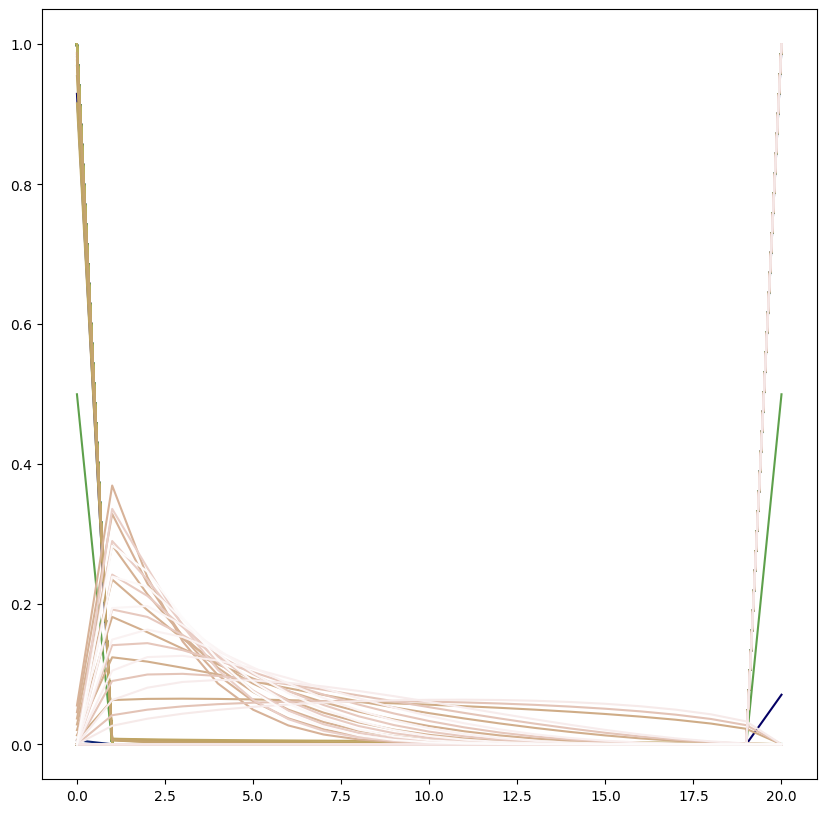

In [32]:
beta_weightings.plot(colormap="gist_earth",legend=False,figsize=[10,10])

In [33]:
list3 = np.linspace(-1.5, 1.5, 15).tolist()
expon_combos = list(product(list3, list3))

In [34]:
nlags = 21
expon_weightings = pd.DataFrame()
for combo in expon_combos:
    expon_weightings = pd.concat([expon_weightings,
                                  pd.Series(ExpAlmonWeights(*combo).weights(nlags)).rename(str(combo))],
                                 axis=1)

<Axes: >

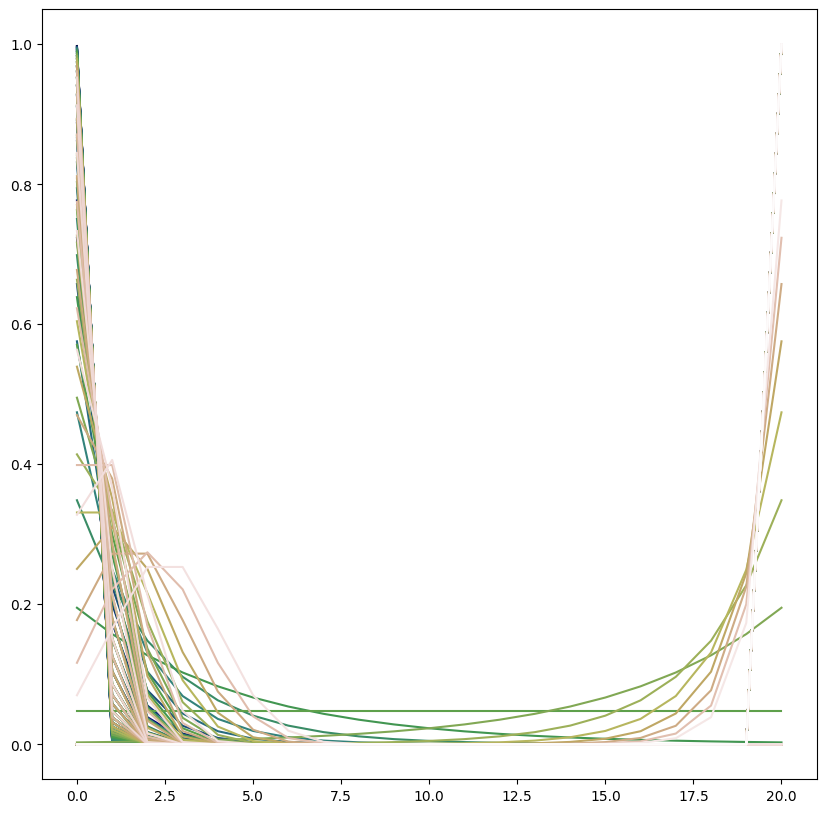

In [35]:
expon_weightings.plot(colormap="gist_earth",legend=False,figsize=[10,10])

In [36]:
nlags = 21
hyperbolic_weightings = pd.DataFrame()
for weight in np.linspace(-3, 3, 124).tolist():
    hyperbolic_weightings = pd.concat([hyperbolic_weightings,
                                       pd.Series(HyperbolicWeights(weight).weights(nlags)).rename(str(weight))],
                                      axis=1)

<Axes: >

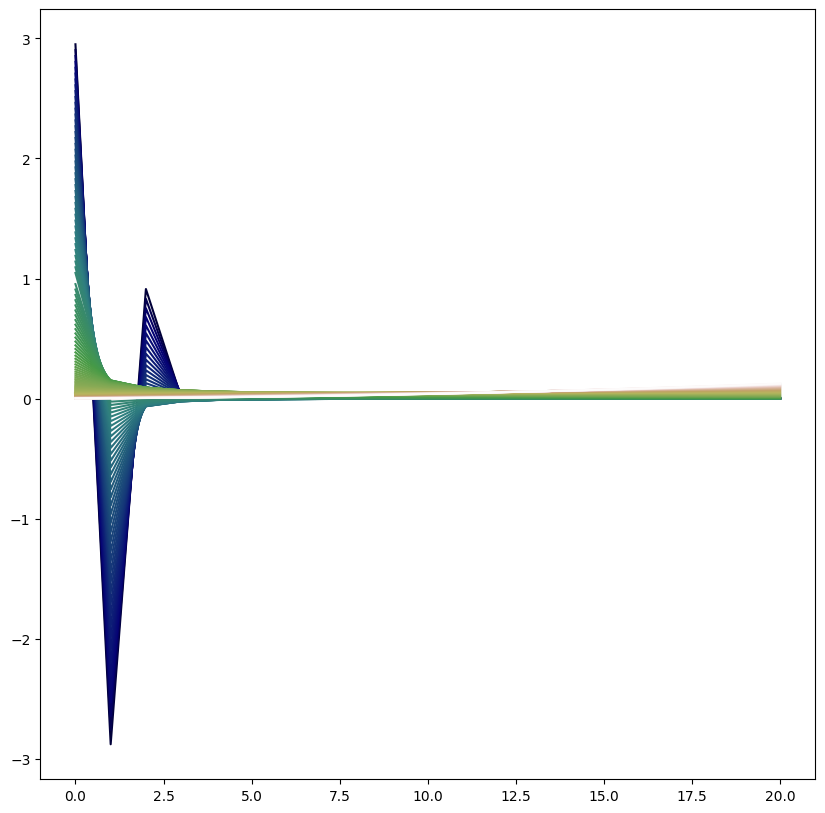

In [37]:
hyperbolic_weightings.plot(colormap="gist_earth",legend=False,figsize=[10,10])

### Part 4: Fit MIDAS Regressoion Model

In [39]:
# Select training data up to end of 2019
x1 = tsx['Close'].rename('TSX_7d_pct_change')['1983-11-01':'2019-12-01'].pct_change(7).dropna()
x2 = tsx['Close'].rename('TSX_14d_pct_change')['1983-11-01':'2019-12-01'].pct_change(14).dropna()
x3 = tsx['Close'].rename('TSX_21d_pct_change')['1983-11-01':'2019-12-01'].pct_change(21).dropna()
x4 = tsx['Close'].rename('TSX_28d_pct_change')['1983-11-01':'2019-12-01'].pct_change(28).dropna()
y = cpi_df.rename('CPI_YoY')['1984-02-01':'2019-12-01']

In [59]:
y

,CPI_YoY
REF_DATE,
1984-02-01,4.5
1984-03-01,4.4
1984-04-01,4.4
1984-05-01,4.4
1984-06-01,4.1
...,...
2019-08-01,2.3
2019-09-01,2.3
2019-10-01,2.3


In [49]:
pd.concat([x1,x2,x3,x4],axis=1).loc['1983-11-30':]

,TSX_7d_pct_change,TSX_14d_pct_change,TSX_21d_pct_change,TSX_28d_pct_change
1983-11-30,0.026419,0.035032,0.041395,0.057299
1983-12-01,0.033327,0.038487,0.041107,0.063838
1983-12-02,0.021960,0.039540,0.031050,0.063603
1983-12-03,0.021960,0.039540,0.031050,0.063603
1983-12-04,0.021960,0.039540,0.031050,0.063603
...,...,...,...,...
2019-11-27,0.005574,0.008409,0.021200,0.036312
2019-11-28,0.006783,0.008384,0.018369,0.038300
2019-11-29,0.005037,0.000687,0.009646,0.026883
2019-11-30,0.005037,0.000687,0.009646,0.026883


In [51]:
model = MIDASRegressor(endog=y,exog=pd.concat([x1,x2,x3,x4],axis=1).loc['1983-11-30':],
                       xlag=30,ylag=1,poly='beta')

In [52]:
fit = model.fit() # this may take a few minutes depending on the data

### Part 5: Evaluate Model Fit

<Axes: xlabel='REF_DATE'>

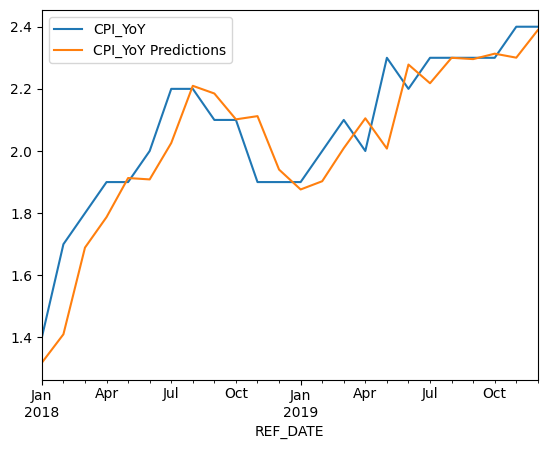

In [53]:
pd.concat([fit.orig_endog,fit.predict()], axis=1)[-24:].plot()

In [60]:
fit.orig_endog

,CPI_YoY
REF_DATE,
1984-03-01,4.4
1984-04-01,4.4
1984-05-01,4.4
1984-06-01,4.1
1984-07-01,4.0
...,...
2019-08-01,2.3
2019-09-01,2.3
2019-10-01,2.3


In [61]:
fit.predict()

,CPI_YoY Predictions
REF_DATE,
1984-03-01,4.451704
1984-04-01,4.319799
1984-05-01,4.339661
1984-06-01,4.322332
1984-07-01,4.058473
...,...
2019-08-01,2.300023
2019-09-01,2.295777
2019-10-01,2.313263


In [54]:
fit.score()

np.float64(0.9666302161127892)

In [58]:
fit.significance()

,coef,std err,t,P>|t|,0.025,0.975
Constant,0.044,0.022,2.013,0.045,0.001,0.087
TSX_7d_pct_change,-12.262,4.866,-2.520,0.012,-21.826,-2.698
TSX_14d_pct_change,8.663,3.350,2.586,0.010,2.077,15.248
TSX_21d_pct_change,0.774,0.618,1.252,0.211,-0.441,1.989
TSX_28d_pct_change,-1.725,0.730,-2.365,0.018,-3.160,-0.291
CPI_YoY t-1,0.977,0.009,110.097,0.000,0.960,0.995


### Part 6: Out-of-sampling predictions

In [ ]:
# Select test data (2020-present)
x1_test = tsx['Adj Close'].rename('TSX_7d_pct_change')['2019-12-01':].pct_change(7).dropna()
x2_test = tsx['Adj Close'].rename('TSX_14d_pct_change')['2019-12-01':].pct_change(14).dropna()
x3_test = tsx['Adj Close'].rename('TSX_21d_pct_change')['2019-12-01':].pct_change(21).dropna()
x4_test = tsx['Adj Close'].rename('TSX_28d_pct_change')['2019-12-01':].pct_change(28).dropna()
y_test = cpi_df.rename('CPI_YoY')['2020-01-01':]

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


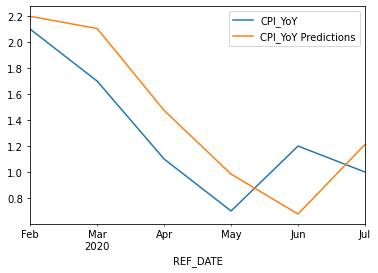

In [ ]:
# Plot predictions
preds = fit.predict(endog=y_test,exog=pd.concat([x1_test,x2_test,x3_test,x4_test],axis=1))
preds.index = y_test.index[1:]
pd.concat([y_test[1:], preds], axis=1).plot()

In [ ]:
!pip install yfinance

In [ ]:
import yfinance as yf

# load the S&P/TSX Composite index historical daily data from Yahoo Finance
tsx = yf.download('^GSPTSE', period='max', interval='1d')